In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

import richdem as rd
#import geotiff

In [2]:
# TODO: import code
from src.CA import *
from src.plotting_utils import *

In [4]:
# Test Direction Calculations

# Replicate results from the paper
# "Cellular Automata for the Flow Simulations on the Earth Surface"
# Cirbus and Podhoranyi (2013)

# Take the sample DEM from the paper
cirbus_dem = np.array(
    [
        [203.83, 201.09, 201.59, 204.31, 200.21, 201.71],
        [204.35, 203.89, 204.13, 200.29, 202.02, 200.20],
        [202.18, 201.27, 203.95, 201.20, 200.46, 201.72],
        [200.74, 202.66, 202.71, 204.34, 200.52, 201.95],
        [201.14, 204.04, 200.64, 203.18, 204.03, 204.35],
        [201.57, 203.51, 200.79, 200.01, 202.00, 202.02]
    ])

# And check our calculated directions with those in the paper
cirbus_directions = np.array([
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 103., 251.,   4., 254.,   0.],
       [  0.,  32., 125., 146.,   5.,   0.],
       [  0., 171.,  77., 255.,   2.,   0.],
       [  0., 255., 128., 237., 238.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]
])

# Are direction calculations correct for all cells?
assert init_direction(cirbus_dem).all() == cirbus_directions.all()

NameError: name 'init_direction' is not defined

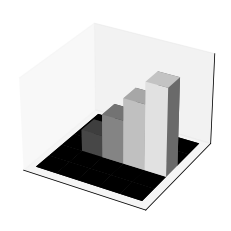

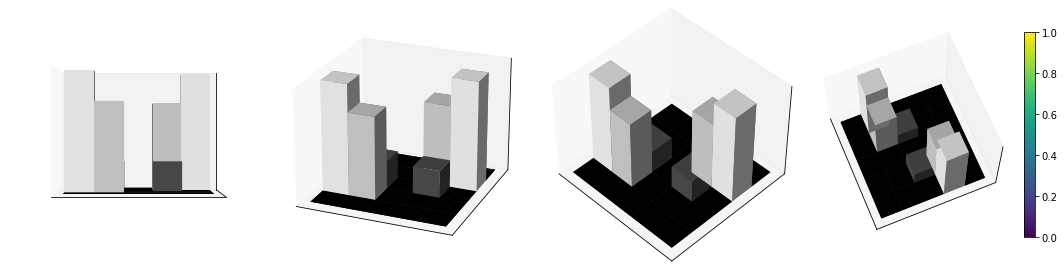

In [64]:
# Test flow accumulation matrix calculation using two predictable cases

# Case 1: A downhill slope. 
# Expectation: Lowest cell has the largest accumulation.

down_stream = np.zeros((5,5))
down_stream[0:4,2] = 128

#ds_flow = generate_flow_acc(down_stream, n_iters = 100000, max_visits = 10)

plot_dem(
    ds_flow,
    cmap = 'Greys_r'
    )

# Case 2: A penrose staircase.
# Expectation: The cells are in a (physically impossible) infinite loop
# so we expect a uniform distribution over flow accumation

# Penrose Staircase (after an Escher binge in quarantine)
penrose = np.zeros((5,5))

penrose[1,2:4] = 2**3
penrose[2:4,3] = 2**7
penrose[3,1:3] = 2**5
penrose[1:3,1] = 2

penrose_acc = generate_flow_acc(penrose, n_iters = 200000, max_visits = 10)
# we expect to see a level, square donut with a hole
plot = orbit_dem(penrose_acc, cmap = 'Greys_r')

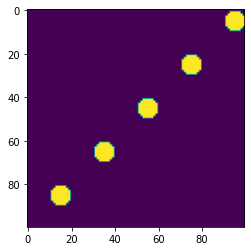

In [57]:
# Test Circular Flow accumulation
from skimage import draw


def draw_clouds(grid, radius = 5, placements = range(5,100,20)):
    """
    Draw clouds of water in a grid.
    """
    clouds = np.zeros_like(grid)

    for p in placements:
        ro,co = draw.disk((p,grid.shape[0] - p), radius, shape = clouds.shape)

        clouds[ro,co] = 1

        
    return clouds


cloud_test = draw_clouds(np.zeros((100,100)))

# pick a random cloud
plt.imshow(cloud_test)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


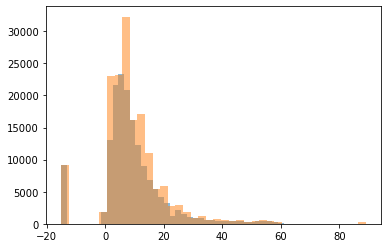

rdarray(0.894725)

In [58]:
# Test gradient calculation against richdem module

path = './media/beauford.npz'
with np.load(path) as data:
    dem = data['beauford']

dem = rd.rdarray(dem[400:800,400:800], no_data=-9999)
slope = rd.TerrainAttribute(dem, attrib='slope_degrees')

slopes_test = init_slope(dem)

plt.hist(np.array(slope.flatten(), dtype = np.int8), alpha =  0.5, bins = 40)
plt.hist(np.array(slopes_test.flatten(), dtype = np.int8), alpha = 0.5, bins = 40)
plt.show()

# Assert no angles are greater than 90
assert np.sum(np.where(slopes_test > 90, 1, 0)) == 0

# check accuracy of slope measurement equal between two arrays
np.sum(slopes_test == slope)/slopes_test.size

In [60]:
# Test the exactness of the gradient calculation on toy basin data
basin = create_basin()
basin_arr = np.array(basin[...,2], dtype = np.float16)

rd_basin = rd.rdarray(basin[...,0], no_data=-9999)
rd_deg = np.array(rd.TerrainAttribute(rd_basin, attrib='slope_degrees'), dtype = np.float16)

rd_basin.all() == basin_arr.all()

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


rdarray(True)

In [ ]:
# Test, visually, how a large water column (10m) flows into a basin 
basin = create_basin(N = 10)
basin[...,1] = 0
# Add a huge column of water, and track its volume
basin[9,9,1] = 100

params = {
    'tau': 0.1,
    'iter': 100,
    'target_cell': [5,5],
    'edgel': 1,
    'n' : 0.02,
    't': 1,
    'plot': True,
    'interval': 2
}

b,fr, fig = run_sim(basin, **params)

# Save the animation (will take a while, see ./media/column_anim.gif)
anim = animation.ArtistAnimation(fig, fr, interval=50, blit=True, repeat_delay=1000)
anim.save(f"./media/column_anim2.gif", writer='ffmpeg', fps=10)

100%|██████████| 60/60 [00:00<00:00, 338.95it/s]


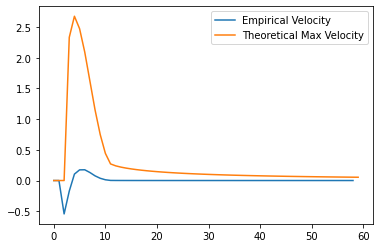

In [5]:
basin = create_basin(N = 10)
results = run_sim(basin)

cell = results['cell_water']

# calc differences beteen iterations in cell
diff = np.diff(cell)*-1

plt.plot(diff, label = 'Empirical Velocity')
# overlay maximum theoretical velocity as a function of height (root(gh))
# make sure that the difference between iterations is less than the maximum theoretical velocity
g = 10
plt.plot(np.sqrt(cell*g), label = "Theoretical Max Velocity")
plt.legend()
plt.show()


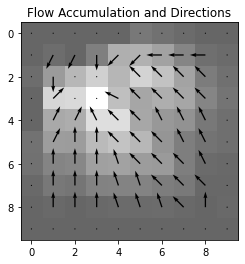

In [19]:
# Test direction plot
basin = create_basin(N = 10)

# Penrose Staircase (after an Escher binge in quarantine)
penrose = np.zeros((5,5))

penrose[1,2:4] = 2**3
penrose[2:4,3] = 2**7
penrose[3,1:3] = 2**5
penrose[1:3,1] = 2

u,v = quiver_directions(basin[...,3])

plt.imshow(generate_flow_acc(basin[...,3]), alpha=0.6, cmap = 
    'Greys_r')
plt.title('Flow Accumulation and Directions')
# make dpi higher for higher resolution
plt.savefig('./media/flow_accdir.png', dpi = 300)

Text(0.5, 1.0, 'Flow Accumulation and Directions')

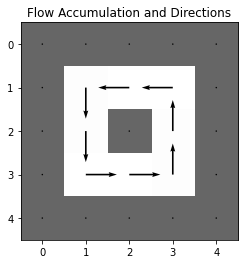

In [71]:
# Penrose Staircase (after an Escher binge in quarantine)
penrose = np.zeros((5,5))

penrose[1,2:4] = 2**3
penrose[2:4,3] = 2**1
penrose[3,1:3] = 2**5
penrose[1:3,1] = 2**7

u,v = quiver_directions(penrose)

plt.imshow(generate_flow_acc(penrose), alpha=0.6, cmap = 'Greys_r')
plt.title('Flow Accumulation and Directions')

In [4]:
# Test Dam functionality: do we get ponding at the front of the dam?
dam_basin = create_basin(10)

# create a tall dam
dam_basin[:, 4, 0] = dam_basin[...,0].max()
# reset water layer, put water only to the right of the dam
dam_basin[:, :, 1] = 0
dam_basin[9,9,1] = 200

# show the dam
# plot_dem(dam_basin[...,0])

# run sim
results = run_sim(dam_basin, iter = 10, t = 1, plot = False, interval = 2)


100%|██████████| 10/10 [00:00<00:00, 248.53it/s]


In [ ]:
def resample_array(a, new_rows, new_cols): 
    '''
    This function takes an 2D numpy array a and produces a smaller array 
    of size new_rows, new_cols. new_rows and new_cols must be less than 
    or equal to the number of rows and columns in a.

    From https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array

    '''
    rows = len(a)
    cols = len(a[0])
    yscale = float(rows) / new_rows 
    xscale = float(cols) / new_cols

    # first average across the cols to shorten rows    
    new_a = np.zeros((rows, new_cols)) 
    for j in range(new_cols):
        # get the indices of the original array we are going to average across
        the_x_range = (j*xscale, (j+1)*xscale)
        firstx = int(the_x_range[0])
        lastx = int(the_x_range[1])
        # figure out the portion of the first and last index that overlap
        # with the new index, and thus the portion of those cells that 
        # we need to include in our average
        x0_scale = 1 - (the_x_range[0]-int(the_x_range[0]))
        xEnd_scale =  (the_x_range[1]-int(the_x_range[1]))
        # scale_line is a 1d array that corresponds to the portion of each old
        # index in the_x_range that should be included in the new average
        scale_line = np.ones((lastx-firstx+1))
        scale_line[0] = x0_scale
        scale_line[-1] = xEnd_scale
        # Make sure you don't screw up and include an index that is too large
        # for the array. This isn't great, as there could be some floating
        # point errors that mess up this comparison.
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lastx = lastx - 1
        # Now it's linear algebra time. Take the dot product of a slice of
        # the original array and the scale_line
        new_a[:,j] = np.dot(a[:,firstx:lastx+1], scale_line)/scale_line.sum()

    # Then average across the rows to shorten the cols. Same method as above.
    # It is probably possible to simplify this code, as this is more or less
    # the same procedure as the block of code above, but transposed.
    # Here I'm reusing the variable a. Sorry if that's confusing.
    a = np.zeros((new_rows, new_cols))
    for i in range(new_rows):
        the_y_range = (i*yscale, (i+1)*yscale)
        firsty = int(the_y_range[0])
        lasty = int(the_y_range[1])
        y0_scale = 1 - (the_y_range[0]-int(the_y_range[0]))
        yEnd_scale =  (the_y_range[1]-int(the_y_range[1]))
        scale_line = np.ones((lasty-firsty+1))
        scale_line[0] = y0_scale
        scale_line[-1] = yEnd_scale
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lasty = lasty - 1
        a[i:,] = np.dot(scale_line, new_a[firsty:lasty+1,])/scale_line.sum() 

    return a 


# Test: Decrease Resolution by resampling
kochi = geotiff.GeoTiff(r'./media/kochi.tif')

dem = np.array(kochi.read())
# if negative set to 0
dem[(dem < 0)] = 0



# plot on 3 columns
fig = plt.figure(figsize=(12,4))

a = resample_array(dem, 200, 200)
b = resample_array(dem, 50, 50)
c = resample_array(dem, 10, 10)

# 3d projection

from src.plotting_utils import plot_dem

ax = fig.add_subplot(1, 3, 1, projection='3d')
# add title
ax.set_title('Size = (200,200)')
plot_dem(a, ax = ax)
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_title('Size = (50,50)')
plot_dem(b, ax = ax)
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.set_title('Size = (10,10)')
plot_dem(c, ax = ax)

# Set overall title
fig.suptitle('Resampling a DEM')
plt.show()

In [ ]:
### Compare FA matrix with CA
path = './media/beauford.npz'
with np.load(path) as data:
    dem = data['beauford']

# cachement size   
c = 100
dem = dem[500:500+c, 500:500+c]

beauford = init_grid(dem, kind = 'everywhere', fill = 0.05)

params = {
    'tau': 0.1,
    'iter': 100,
    'target_cell': [5,5],
    'edgel': 1,
    'n' : 0.02,
    't': 60,
    'plot': False,
    'interval': 2
}

res = run_sim(beauford, **params)


# Add column subplots
fig = plt.figure(figsize = (10,5), )
ax = fig.add_subplot(121, projection='3d')
plot_water(beauford[...,0], beauford[...,1], ax = ax, rotation  = 60)
# set ax title
ax.set_title(f'Simulated Persistent Rainfall after {res["iter"]} iterations')

# Add a smaller subplot to right
fig.add_subplot(122)
plt.imshow(generate_flow_acc(beauford[...,3]), cmap = 'magma')
# set title
plt.title('Flow Accumulation for Beauford DEM')

# save figure
#plt.savefig('./media/flow_acc_beau.png')

In [ ]:
# Test Rainfall over a month
avg = 700
tot = 0

iters = np.arange(0, 60*12 * 30)
rain = np.zeros(len(iters))

for i in iters:
    rain[i] = get_rain(i, avg = avg)

tot+=np.sum(rain)

np.allclose([tot*1000], [avg], rtol=1, atol=1)

# Old Update Rules

Attempted an implementation of the Podranyi paper, which turned out to be a huge waste of time!

In [ ]:
# Abandoned transition rules from the awful first paper

# liquid loss = inflitration
depth = np.linspace(0,10,100)
s = np.linspace(0,100,100)
n = 0.02
w = 10

# Flow rate 
def fluid_velocity(depth = 4, s=np.pi, n = 0.2):
    """Params
        cell  (array[4]): a sim cell
        depth[m]   (int): depth of water column at cell
        s[deg]   (float): slope of cell
        n        (float): Manning roughness coefficient."""

    #depth = cell[0] 
    #s     = cell[2] 

    return depth**(2/5)*np.sqrt(s) / n


def time_through_cell(cell, width = 10):
    """Params
        v    (float): calculated fluid_velocity through cell
        width  (int): width of cell/raster resolution"""

    v = fluid_velocity(cell)

    return width/v

def volume_entering_cell(depth, width, v, t = 1):
    return depth * width * v * t

# Meet flooding conditions
def is_flooded(cell, t = 1):
    """check if cell is flooded
    Params
    Returns
        flooded? (bool)"""
    return time_through_cell(cell) > t


def infiltration_velocity(Ks = 2, Hf = 1, F = 2, Md = 3):
    """
    Params
        Ks(mmh^-1) : hydraulic conductivity
        Hf(mm)     : suction lift
        Md(mm)     : soil moisture deficit
        F          : total depth of infiltration
    """
    # How fast water seeps into the soil
    # infiltration_velocity << fluid_velocity
    return Ks*(1 + Hf*Md/F)